## Image classification Batch Norm

***NOTE***

Be sure to use hardware acceleration to use the GPU. Click on `Runtime`, change `runtime type`, and select `GPU` for the *hardware accelerator* option.

* Training deep neural networks is difficult. Getting them to converge in a reasonable amount of time can be tricky. In this section, we describe batch normalization, a popular and effective technique that consistently accelerates the convergence of deep networks

* When working with data, we often preprocess before training. Choices regarding data preprocessing often make an enormous difference in the final results.

* Our first step when working with real data was to standardize our input features to have a mean of 0 and s.dev of 1. Consider a feature with values [0 to 10] another with values [10 to 10,000].

* Batch normalisation helps with covariance shift problems (when the distribution of the data changes), for example training a network on images of black cats, and then applying it to images of ginger cats. If your network learns a mapping f: x -> y, and the distribution of x changes, then you might need to re-train the model. Why is covariate shift a problem and how does batch norm help us?

* Consider some layer *i* in a network. This layer will have a number of inputs from the previous layer *i-1*. Let us pretend there are 4 inputs to layer *i*, x1, x2, x3 and x4. Of course x1,...x4 are the result of many layers and have undergone many multiplications of weights and biases. But here, let us treat x1, ... x4 and a vector input to layer *i*.

* So the job of layer *i* is to learn the weights and biases which will be multiplied and added to x1, x2, x3 and x4 such that these minimise our loss function.

* Now the idea of covariate shift will kick in. In our example we considered layer *i* and intput x1, ..., x4 and how it has to do a good job in minimising the loss function. But in reality, x1, ..., x4 is the result of several previous layers (weights and biases) and activation functions. So in fact, when the previous layers change (weight changes) the values of x1, ... x4 will change. So our mapping from x -> y has changed! In fact, the values of x1, ... x4 in our hidden layer are continuously changing (because the layers before it change). I.e., x1,... x4 is continuously having the covariate shift problem.

* The purpose of batch norm, is to reduce the amount by which there is a change in distribution for the hidden unit outputs. Of course, the values will always change, this is normal since the weights of earlier layers will be updated. But batch norm's job is to ensure that the mean and standard deviation for each layer is the same. 

* In short: updating network parameters in earlier layers can affect the distribution of the input values to later layers. Batch norm tries to ensure that the input values to a layer does not change drastically. 

* Which mean and standard deviation will the network ensure? These two values are network parameters, gamma and beta. Each layer will have it's own gamma and beta.

* You decide on which layer you want to apply batch normalisation to.

* Batch norm works as follows. It works on the mini-batches in our epochs. So say, 32 examples if our batch size is 32. We do a forward pass as always from the input to the output layer. A layer which uses batch normalisation will receive values from the previous layer (the output from activation functions). It then normalises these values by subtracting the mean and dividing by the standard deviation. Next, we multiply gamma and add on beta. Gamma is our scaling parameter and beta our additive parameter. I.e. gamma and beta are setting a new mean and standard deviation which are learnt by back propagation and not by a user (i.e. hyperpameters). So the network can learn optimal new means and standard deviations. Why don't we set the output of batch norm simply to the normalised values (i.e. why add scaling and shifting)? This would restrict the network to a mean of 0 and s.dev of 1. Instead, we allow the network to have any mean and s.dev such that the loss is minimised as optimally as possible.

* Are we done yet? No, there is a small complication that happens at test time. During training, the batch norm process is applied on the batches of data which are used to update beta and gamma. However, to use this at test time we need to make some modifications. During training, we will have the correct number of examples filling up the batch. However, at test time, you might not have the necessary amount of data to fill up the batch (e.g. batch size of 128). You might only have 1, 2 or 3 data points that you want to predict on.

* Batch norm has two non-trainable pamaters (not trained via gradient descent), namely, an exponentially weighted average, EWAs (moving average), of the mean and the movine average of the s.dev across all the mini batches. In other words, for each layer there will be a mean which is calculated for batch 1, 2, 3, ... so on. And for each layer there will be a standard deviation which is calculated for batch 1, 2, 3, ... so on. Now at testing time, you would use these EWAs.

* Due to these extra calculations, each epoch takes longer to complete. 

Below is an example of batch norm applied to the output of an activation from the previous layer.
![](https://miro.medium.com/max/1286/0*OyVlWTVJufivCfjT.png)

Here you see that each batch normalisation layer maintains it's own gamma and beta and how the moving average is calculated for each layer too
![](https://miro.medium.com/max/1400/0*4uvh_GjZWzmSX4AX.png)

All calculations
![](https://miro.medium.com/max/1400/1*VsN_9_AN2ji8hCZYSTTV0w.png)

credits for images above: https://towardsdatascience.com/batch-norm-explained-visually-how-it-works-and-why-neural-networks-need-it-b18919692739#:~:text=Scale%20and%20Shift&text=Unlike%20the%20input%20layer%2C%20which,to%20it%20a%20factor%2C%20beta.


Two great videos which reiterate these points worth watching:

1) https://www.youtube.com/watch?v=nUUqwaxLnWs

2) https://www.youtube.com/watch?v=5qefnAek8OA


## Imports first

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization
from keras.datasets import fashion_mnist
import numpy as np
import matplotlib.pyplot as plt
from keras.utils import np_utils
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import pandas as pd
%matplotlib inline

import tensorflow as tf
print(tf.__version__)

2.9.2


## Load the dataset

In [ ]:
# load data
(X_train, Y_train), (X_test, Y_test) = tf.keras.datasets.fashion_mnist.load_data()

4422102/4422102 [==============================] - 0s 0us/step


## View the shape

In [ ]:
print('Training data shape : ', X_train.shape, Y_train.shape)

Training data shape :  (60000, 28, 28) (60000,)


In [ ]:
print('Testing data shape : ', X_test.shape, Y_test.shape)

Testing data shape :  (10000, 28, 28) (10000,)


## Find the unique numbers from the train labels

In [ ]:
classes = np.unique(Y_train)
nClasses = len(classes)
print('Total number of outputs : ', nClasses)
print('Output classes : ', classes)

Total number of outputs :  10
Output classes :  [0 1 2 3 4 5 6 7 8 9]


## Plot some of the data

Text(0.5, 1.0, 'Ground Truth : 1')

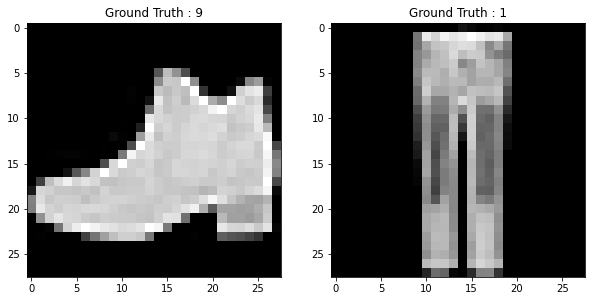

In [ ]:
data_point = 15

plt.figure(figsize=[10,5])
 
# Display the first image in training data
plt.subplot(121)
plt.imshow(X_train[data_point,:,:], cmap='gray')
plt.title("Ground Truth : {}".format(Y_train[data_point]))
 
# Display the first image in testing data
plt.subplot(122)
plt.imshow(X_test[data_point,:,:], cmap='gray')
plt.title("Ground Truth : {}".format(Y_test[data_point]))

## Reshape needed

Keras wants to know the depth of an image. 

For CNNS, Keras wants the format of the data as follows: [batches, width, height, depth]. 

In this case the colour channel/depth of the images is 1. Currently the shape is:

In [ ]:
X_train.shape

(60000, 28, 28)

In [ ]:
X_train.shape

(60000, 28, 28)

But this doesn't have a depth value. So we can reshape it

In [ ]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2], 1))

In [ ]:
X_train.shape

(60000, 28, 28, 1)

In [ ]:
X_train.shape

(60000, 28, 28, 1)

## View the shape

In [ ]:
print('Training data shape : ', X_train.shape, Y_train.shape)

Training data shape :  (60000, 28, 28, 1) (60000,)


In [ ]:
print('Testing data shape : ', X_test.shape, Y_test.shape)

Testing data shape :  (10000, 28, 28, 1) (10000,)


## Convert from categorical labels to one-hot encoded vectors

In this case there are 10 classes so we can tell the function to convert into a vector of length 10

In [ ]:
Y_train = np_utils.to_categorical(Y_train, 10)
Y_test = np_utils.to_categorical(Y_test, 10)
num_classes = 10

## Small twist!

API: https://www.tensorflow.org/api_docs/python/tf/data/Dataset

In [ ]:
train_ds = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
test_ds = tf.data.Dataset.from_tensor_slices((X_test, Y_test))

In [ ]:
def resize_images(image, label):
    # Normalize images to have a mean of 0 and standard deviation of 1
    image = tf.image.per_image_standardization(image)

    image = tf.image.resize(image, (224,224))
    return image, label

In [ ]:
train_ds = (train_ds
                  .map(resize_images)
                  .shuffle(buffer_size=10000)
                  .batch(batch_size=64, drop_remainder=True))
test_ds = (test_ds
                  .map(resize_images)
                  .batch(batch_size=10, drop_remainder=False))

## Create a CNN model

In [ ]:
def baseline_model():
    # create model
    model = tf.keras.Sequential()

    model.add(tf.keras.layers.Conv2D(filters=96, kernel_size=11, strides=4,input_shape=(224,224,1),activation="relu"))
    model.add(BatchNormalization())
    model.add(tf.keras.layers.MaxPool2D(pool_size=3, strides=2))
    model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=5, padding='same',activation="relu"))
    model.add(BatchNormalization())
    model.add(tf.keras.layers.MaxPool2D(pool_size=3, strides=2))
    model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding='same',activation="relu"))
    model.add(BatchNormalization())
    model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding='same',activation="relu"))
    model.add(BatchNormalization())
    model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding='same',activation="relu"))
    model.add(BatchNormalization())
    model.add(tf.keras.layers.MaxPool2D(pool_size=3, strides=2))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(128,activation="relu"))
    model.add(BatchNormalization())
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(128,activation="relu"))
    model.add(BatchNormalization())
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(10, activation="softmax"))

    # Compile the model
    model.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])
    return model

In [ ]:
model = baseline_model()

## Determine the number of trainable parameters

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 54, 54, 96)        11712     
                                                                 
 batch_normalization (BatchN  (None, 54, 54, 96)       384       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 26, 26, 96)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 26, 26, 32)        76832     
                                                                 
 batch_normalization_1 (Batc  (None, 26, 26, 32)       128       
 hNormalization)                                                 
                                                        

## Begin training

In [ ]:
model.fit(train_ds, epochs=2, batch_size=32, verbose=1)

Epoch 1/2
937/937 [==============================] - 55s 38ms/step - loss: 0.6084 - accuracy: 0.7896
Epoch 2/2
937/937 [==============================] - 39s 40ms/step - loss: 0.3789 - accuracy: 0.8686


## Predict on all the test data

In [ ]:
predictions = model.predict(test_ds)

1000/1000 [==============================] - 5s 4ms/step


In [ ]:
predictions.shape

(10000, 10)

In [ ]:
correct_values = np.argmax(Y_test,axis=-1)
predicted_classes = np.argmax(predictions,axis=-1)

In [ ]:
accuracy_score(predicted_classes,correct_values)*100

87.56

More efficient:

In [ ]:
targets = []
for x,y in test_ds.as_numpy_iterator():
  targets.extend(y)

In [ ]:
np.asarray(targets).shape

(10000, 10)

In [ ]:
accuracy_score(predicted_classes,np.argmax(targets,axis=-1))*100

87.56

## Tasks:

* Without removing any layers, reduce the number of trainable parameters. How does this compare in testing performance? Try this a few times to get the best performance you can.

* How did you decide on what to change?

* What would make this process faster? 

* How do you think this relates to implementing deep learning models in practice? What are some of the challenges?